#ECS629U/P ARTIFICIAL INTELLENGENCE [Spring 2021 /Dr.Yorgos Tzimiropoulos]
* Name: Liang Li
* Student ID: 200909538


## Pat 0.Environment Setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import random
import numpy as np
import numpy
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.utils.data as Data


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
Nf =2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)


In [ ]:
#Hyperparameter 1 [BASIC]
LR = 1e-3
MAX_EPOCH = 200
BATCH_SIZE = 20 

In [ ]:
#Hyperparameter 2 [CHECK THE INFLUENCE OF SMALLER LEARNING RATE]
LR = 1e-4
MAX_EPOCH =200
BATCH_SIZE =20


In [ ]:
#Hyperparameter 3 [CHECK THE INFLUENCE OF LARGER LEARNING RATE]
LR =1e-1
MAX_EPOCH = 200
BATCH_SIZE = 20

In [ ]:
#Hyperparameter 3 [CHECK THE INFLUENCE OF BATCH_SIZE]
LR =1e-3
MAX_EPOCH = 200
BATCH_SIZE = 80

##Part 1.Training dataset and dataloader

In [ ]:
#Split Data 
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [ ]:
#Creat training dataset and dataloader
import torch.utils.data as Data
train_Dataset = Data.TensorDataset(X_train,y_train)
train_Dataloader = Data.DataLoader(dataset=train_Dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)

val_Dataset = Data.TensorDataset(X_val,y_val)
val_Dataloader = Data.DataLoader(dataset=val_Dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)


##Part 2.Encoder and Decoder

In [ ]:
#Define Encoder #Used to pick function
class Encoder(nn.Module):
  def __init__(self, num_inputs,num_hidden_1,num_hidden_2, num_outputs):
    super(Encoder, self).__init__()

    self.num_inputs=num_inputs
    self.num_hidden_1=num_hidden_1
    self.num_hidden_2=num_hidden_2
    self.num_outputs=num_outputs

    self.encoder_input_layer  = nn.Linear(in_features=num_inputs, out_features=num_hidden_1)
    self.encoder_hidden_layer = nn.Linear(in_features=num_hidden_1, out_features=num_hidden_2)
    self.encoder_output_layer = nn.Linear(in_features=num_hidden_2, out_features=num_outputs)

  def forward(self, x):
    x.to(device)
    x1 = F.relu(self.encoder_input_layer(x))
    x2 = F.relu(self.encoder_hidden_layer(x1))
    feature_representation = self.encoder_output_layer(x2)
    
    return feature_representation


In [ ]:
#Define Decoder #Used to do regression
class Decoder(nn.Module):
  def __init__(self, num_inputs,num_hidden_1,num_hidden_2, num_outputs):
    super(Decoder, self).__init__()
    
    self.num_inputs=num_inputs
    self.num_hidden_1=num_hidden_1
    self.num_hidden_2=num_hidden_2
    self.num_outputs=num_outputs

    self.decoder_input_layer  = nn.Linear(in_features=num_inputs, out_features=num_hidden_1)
    self.decoder_hidden_layer = nn.Linear(in_features=num_hidden_1, out_features=num_hidden_2)
    self.decoder_output_layer = nn.Linear(in_features=num_hidden_2, out_features=num_outputs)

  def forward(self, x):
    x.to(device)
    x1 = F.relu(self.decoder_input_layer(x))
    x2 = F.relu(self.decoder_hidden_layer(x1))
    y_pred = self.decoder_output_layer(x2)
    
    return y_pred




In [ ]:
# Model instantiation and initialisation 
def init_weights(m):
  if type(m) == nn.Linear:
     #torch.nn.init.normal_(m.weight, std=0.01)
     #torch.nn.init.zeros_(m.bias)
     torch.nn.init.xavier_uniform_(m.weight)
     m.bias.data.fill_(0.001)

In [ ]:
# Create and initialize encoder:
enc_inputs, enc_hidden_1, enc_hidden_2, enc_outputs = 2, 8 , 4, 5
encoder = Encoder(enc_inputs, enc_hidden_1, enc_hidden_2, enc_outputs)
encoder.apply(init_weights)
# Create and initialize decoder:
dec_inputs, dec_hidden_1, dec_hidden_2, dec_outputs= 6 , 8 , 4, 1
decoder=Decoder(dec_inputs, dec_hidden_1, dec_hidden_2, dec_outputs)
decoder.apply(init_weights)



Decoder(
  (decoder_input_layer): Linear(in_features=6, out_features=8, bias=True)
  (decoder_hidden_layer): Linear(in_features=8, out_features=4, bias=True)
  (decoder_output_layer): Linear(in_features=4, out_features=1, bias=True)
)

##Part 3.The Optimizer and The Loss

In [ ]:
# Adam optimizer with learning rate LR
en_optimizer=optim.Adam(encoder.parameters(),lr=LR) #encoder optimizer
de_optimizer=optim.Adam(decoder.parameters(),lr=LR) #decoder optimizer

# mean-squared error loss
criterion = nn.MSELoss()

##Part 4.Training script (trainining model and training loss)

In [ ]:
epoch_period=[]
epoch_loss=[]
for epoch in range(MAX_EPOCH):
  epoch_period.append(epoch)

  for X,y in train_Dataloader:
    #Encoder Part
     # number of context pairs
    context_points=numpy.random.randint(1,40)
    pairs=numpy.random.randint(1,40,context_points)
    xc=X[:,pairs,:]
    yc=X[:,pairs,:]
    enc_Input = torch.cat((xc,yc),2)#concat xc and yc
    r_C = torch.mean(encoder(enc_Input),dim=1,keepdim=True)#average output of encoder #get r_C

    #Decoder Part
    dec_Input = torch.cat((r_C.expand(80,40,5),X),dim=-1)#concat r_C and X
    dec_Output = decoder(dec_Input)

    # compute training loss
    loss=criterion(dec_Output,y)

    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    en_optimizer.zero_grad()
    de_optimizer.zero_grad()

    # compute accumulated gradients
    loss.backward()

    # perform parameter update based on current gradients
    en_optimizer.step()
    de_optimizer.step()
  #print the result  
  print(f'epoch:{epoch+1}',f'loss:{loss.data}')
  epoch_loss.append(loss.item())



epoch:1 loss:0.5175437927246094
epoch:2 loss:0.47631022334098816
epoch:3 loss:0.4240248501300812
epoch:4 loss:0.4644961655139923
epoch:5 loss:0.38458573818206787
epoch:6 loss:0.3710407614707947
epoch:7 loss:0.3443809449672699
epoch:8 loss:0.35642552375793457
epoch:9 loss:0.3561280369758606
epoch:10 loss:0.3313768804073334
epoch:11 loss:0.3305703401565552
epoch:12 loss:0.39152809977531433
epoch:13 loss:0.29760584235191345
epoch:14 loss:0.2600685954093933
epoch:15 loss:0.2754046320915222
epoch:16 loss:0.25959864258766174
epoch:17 loss:0.294004887342453
epoch:18 loss:0.24846363067626953
epoch:19 loss:0.2607727348804474
epoch:20 loss:0.26575127243995667
epoch:21 loss:0.2796729803085327
epoch:22 loss:0.2562069594860077
epoch:23 loss:0.275187224149704
epoch:24 loss:0.2691045105457306
epoch:25 loss:0.2559449076652527
epoch:26 loss:0.26585108041763306
epoch:27 loss:0.26033657789230347
epoch:28 loss:0.2824645936489105
epoch:29 loss:0.2529003918170929
epoch:30 loss:0.2566455006599426
epoch:31 lo

Text(0, 0.5, 'LOSS')

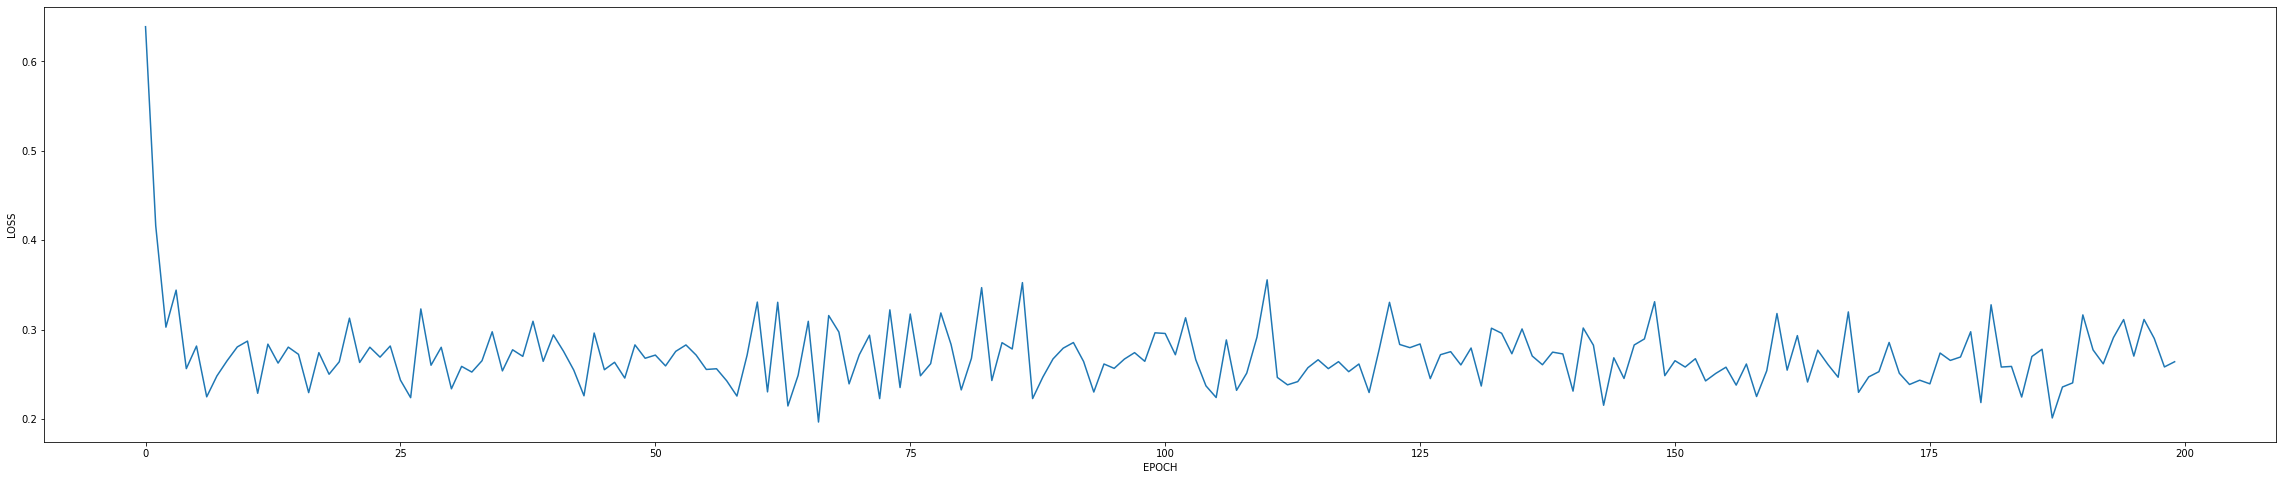

In [ ]:

#Training Loss Plot with Hyperparameter 1: LR = 1e-3 / MAX_EPOCH = 200 / BATCH_SIZE = 20 

plt.figure(figsize=(40,8))
plt.plot(epoch_period,epoch_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
#As you can see from the figure , the decreasing of loss is much stable than hyperparameter 2 and 3

Text(0, 0.5, 'LOSS')

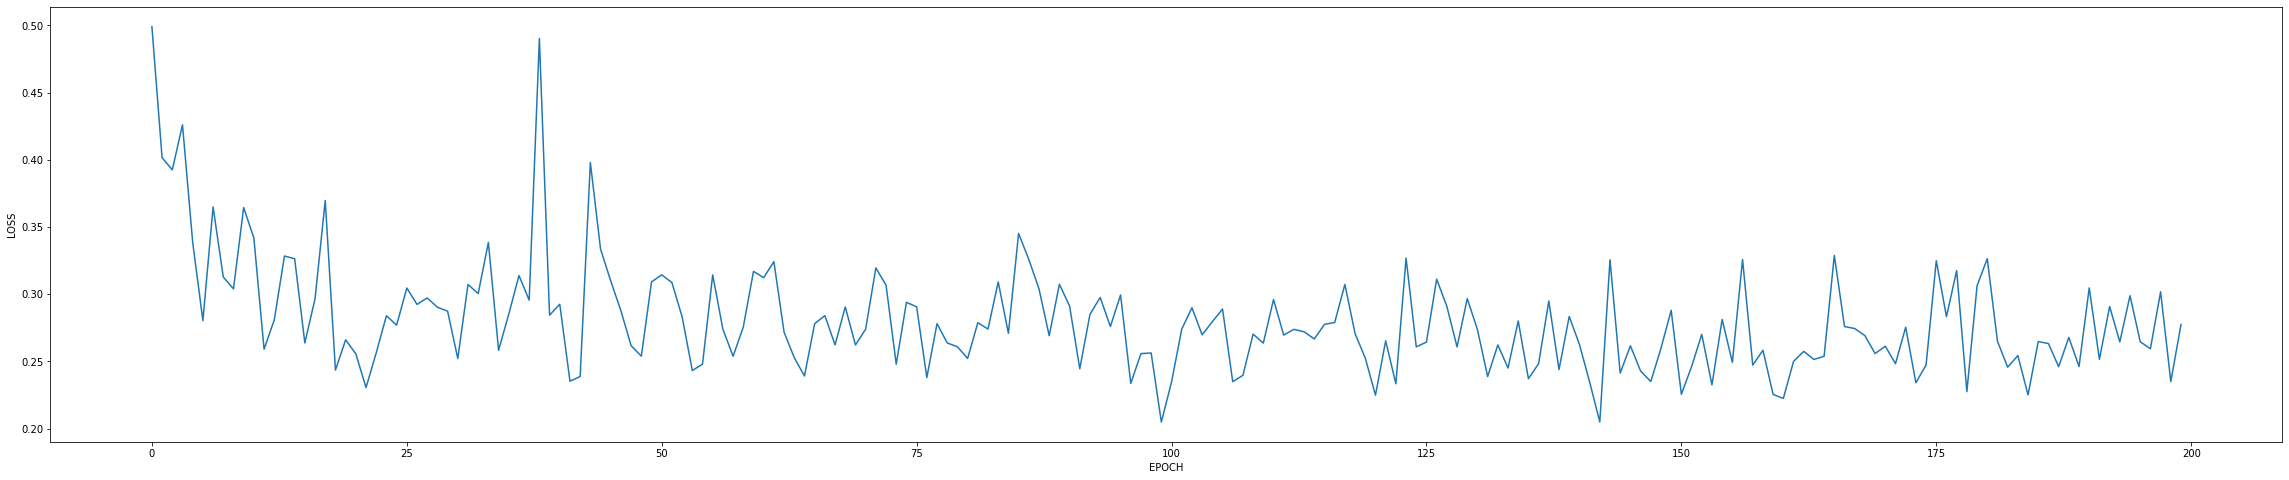

In [ ]:
#Training Loss Plot with Hyperparameter 2: LR = 1e-4 / MAX_EPOCH = 200 / BATCH_SIZE = 20 

plt.figure(figsize=(40,8))
plt.plot(epoch_period,epoch_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')

#As you can see from the plot, the decreasing of training loss is quite volatile than first plot.
#I think it is because the learning rate is small.The training progress is much slower than that learning rate is 1e-3.



Text(0, 0.5, 'LOSS')

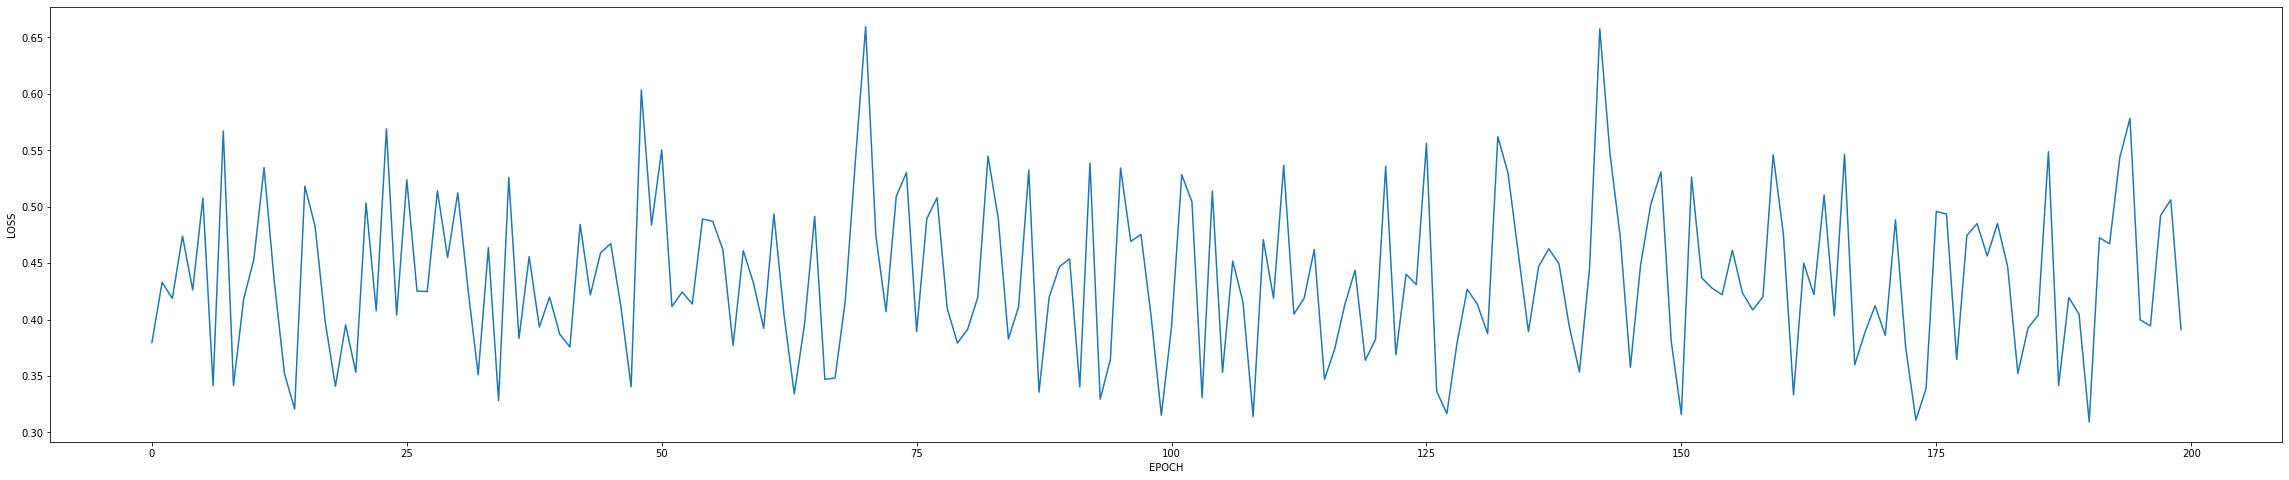

In [ ]:
#Training Loss Plot with Hyperparameter 3: LR = 1e-1 / MAX_EPOCH = 200 / BATCH_SIZE = 20 

plt.figure(figsize=(40,8))
plt.plot(epoch_period,epoch_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
#As you can see from the plot,the decreasing of training loss has great volatility then previous two plots. 
#The learning rate is so high 
#You can see the training loss is small at the begining ,but changes big at latter.
#So it is better to choose a smaller learning rate that can help model to capture suitable parameters easily and quickly.

Text(0, 0.5, 'LOSS')

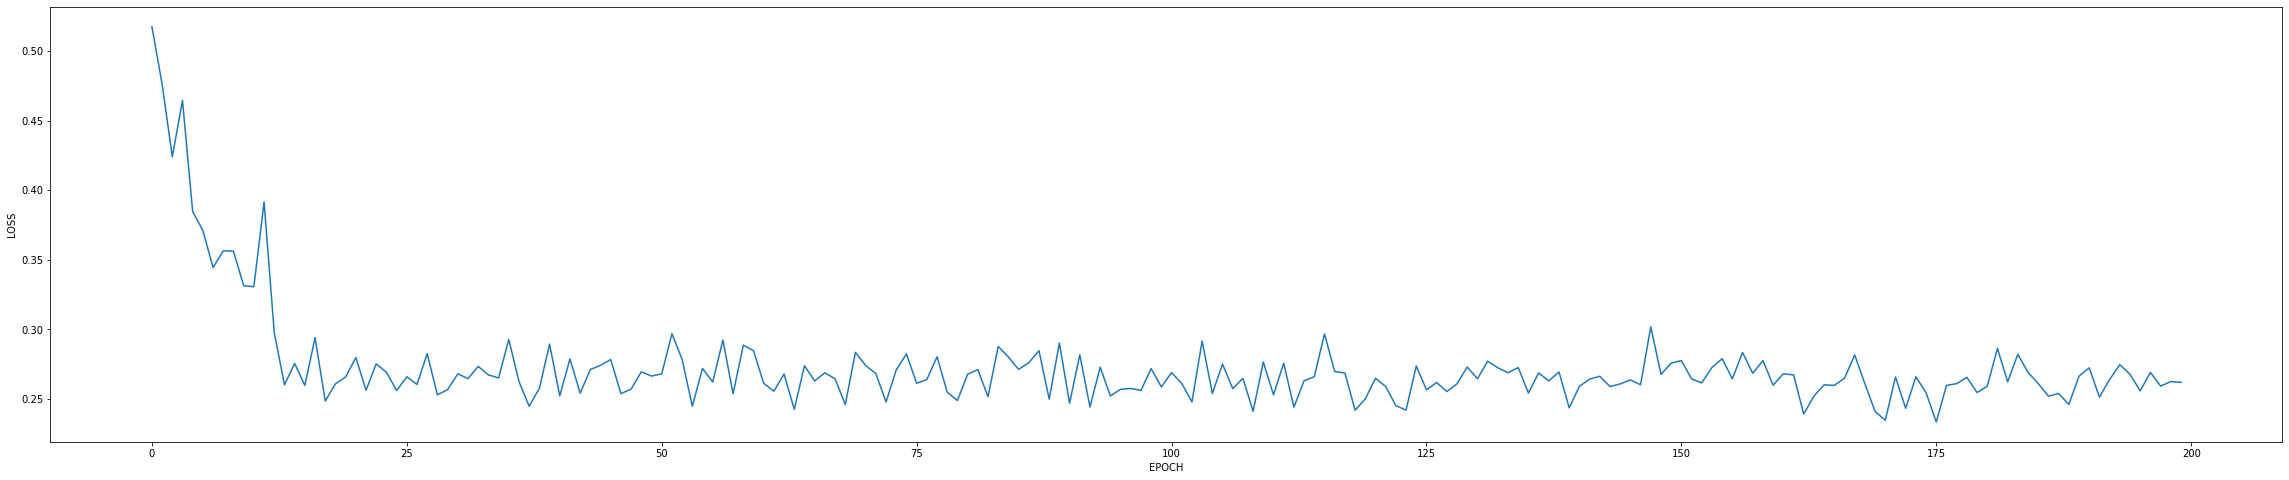

In [ ]:
#Training Loss Plot with Hyperparameter 4: LR = 1e-3 / MAX_EPOCH = 200 / BATCH_SIZE = 80 

plt.figure(figsize=(40,8))
plt.plot(epoch_period,epoch_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')

#As you can see from the plot,the model with lr=1e-3 and batch_size=80 performs quite well than previous model.
#So it is better to increase the number of batch_size that can help model performing better.

##Part 5. Evaluate on Validation Data and Plot predictions

In [ ]:
#Evaluation on Validation Data
val_loss=[]
val_predictor=[]
for val_X,val_y in val_Dataloader:
    #Encoder Part
    #Select random Context_Points
    context_points=numpy.random.randint(1,40)
    pairs=numpy.random.randint(1,40,context_points)
    xc=val_X[:,pairs,:]
    yc=val_X[:,pairs,:]
    enc_Input = torch.cat((xc,yc),2)#concat xc and yc
    r_C = torch.mean(encoder(enc_Input),dim=1,keepdim=True)#average output of encoder #get r_C

    #Decoder Part
    dec_Input = torch.cat((r_C.expand(80,40,5),val_X),dim=-1)#concat r_C and X
    dec_Output = decoder(dec_Input)
    #Calculate loss
    loss=criterion(dec_Output,val_y)
    val_loss.append(loss.item())
    val_predictor.append(dec_Output)
  

Text(0, 0.5, 'Y')

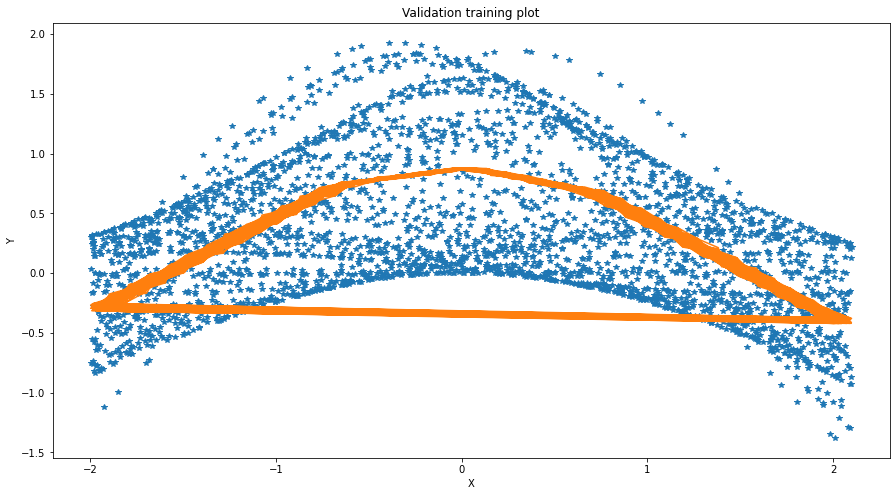

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(val_X.flatten(),val_y.flatten(),'*')
plt.plot(val_X.flatten(),val_predictor[0].flatten().detach().numpy())
plt.title('Validation training plot')
plt.xlabel('X')
plt.ylabel('Y')


#As you can see from validation training plot, the model doesn't perform very well .
#It can capture some pattern but not whole pattern,however it is understandable.
#The relationship between different data is not linear,because they are produced by different function. 
#I can't make a reasonable comment if i only see the preditors and groundtruth.

Text(0.5, 1.0, 'Training Loss on Validation Dataloader')

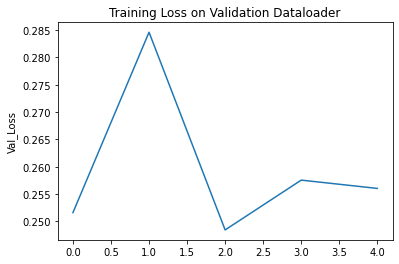

In [ ]:
plt.ylabel('Val_Loss')
plt.plot(val_loss)
plt.title('Training Loss on Validation Dataloader')
#As u can see from the plot, the training loss of validation dataloader is progressly decreassing.
#So the performance of model is ok.

In [ ]:
#Evaluation on Testing Data
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/AI/CW/test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 3# i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']

In [ ]:
input=encoder(torch.cat((x_c,y_c),dim=-1))
r_c=torch.mean(input,1,True)
r_c=torch.cat((r_c.expand(1,40,5),x_t),dim=-1)
y_preds=decoder(r_c)
y_preds

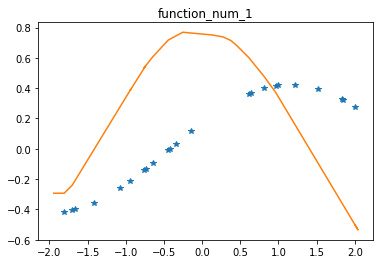

In [ ]:
# Function1
plt.plot(x_c[0,:,0],y_c[0,:,0],'*')
plt.plot(x_t[0,:,0],y_preds[0,:,0].detach().numpy())
plt.title(name)
plt.show()

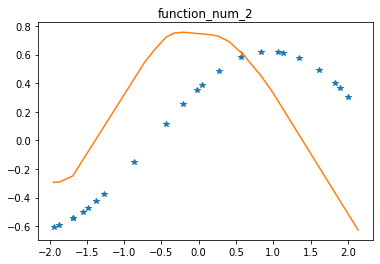

In [ ]:
#Function 2
plt.plot(x_c[0,:,0],y_c[0,:,0],'*')
plt.plot(x_t[0,:,0],y_preds[0,:,0].detach().numpy())
plt.title(name)
plt.show()

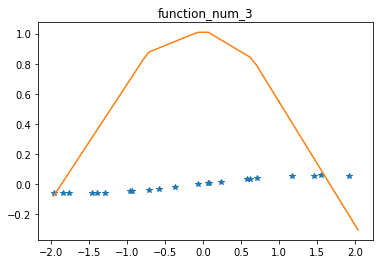

In [ ]:
#Function 3
plt.plot(x_c[0,:,0],y_c[0,:,0],'*')
plt.plot(x_t[0,:,0],y_preds[0,:,0].detach().numpy())
plt.title(name)
plt.show()
#As you can see from the plot, it is obvious that the model is not good at capture flat curve.

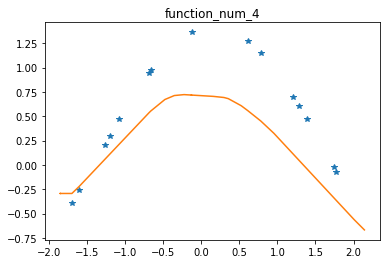

In [ ]:
#Function 4
plt.plot(x_c[0,:,0],y_c[0,:,0],'*')
plt.plot(x_t[0,:,0],y_preds[0,:,0].detach().numpy())
plt.title(name)
plt.show()

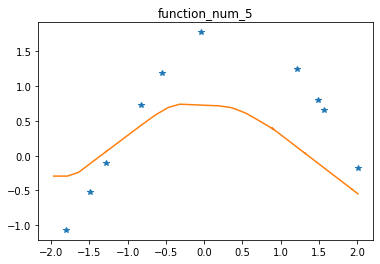

In [ ]:
#Function 5
plt.plot(x_c[0,:,0],y_c[0,:,0],'*')
plt.plot(x_t[0,:,0],y_preds[0,:,0].detach().numpy())
plt.title(name)
plt.show()

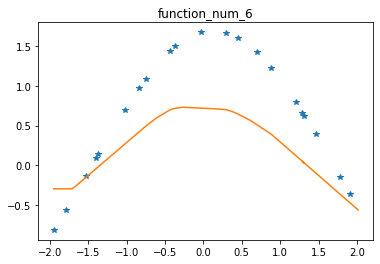

In [ ]:
#Function 6
plt.plot(x_c[0,:,0],y_c[0,:,0],'*')
plt.plot(x_t[0,:,0],y_preds[0,:,0].detach().numpy())
plt.title(name)
plt.show()


##Part 6.Conclusion
* For hyperparameter :
  * In my model ,the best combination of hyperparameter is [LEARNING RATE =1e-3, BATCH_SIZE=80 , MAX_EPOCH=200 ]
  * If the learning rate is too high, it can cause undesirable divergent behavior in my loss function. If the learning rate is too low, training will progress very slowly as I am making very tiny updates to the weights in my network.
  * Large batch size may converge faster can give better performance. Because it may improve the effectiveness of the optimization steps resulting in more rapid convergence of the model performance.

* For model:
  * This model is much like an Autodecoder model but the difference is autoencoder model is a kind of unsupervised learning. This model has labels and belongs to supervised learning. For the encoder part , it is used to pick function that can help decoder to execute regression. 
  * I also search online and find topics that related to self-attention model. I think if I can use soft-attention in encoder and RNN in decoder. The performance will become much better.

* For Testing Part:
  * The model doesn't have a good performance when it tries to fit flat curve.
  * And there are still some losses between predictor and groudtruth. 